In [6]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [11]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/stem",
                             basepath_suffix="_content.csv", drop_short_docs=10)
d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 10)

# d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/")
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()

# OR load initialized and trained wrapper if available
# d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/100train")

2017-04-10 13:04:54,668 : INFO : Loaded 51731 docs from 14 categories
2017-04-10 13:04:54,669 : INFO : Filtering docs shorter than 10 tokens from vocab sample
2017-04-10 13:04:54,692 : INFO : 43395 docs included in vocab init
2017-04-10 13:04:56,998 : INFO : collecting all words and their counts
2017-04-10 13:04:56,999 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-10 13:04:57,204 : INFO : PROGRESS: at example #10000, processed 1377052 words (6751383/s), 63935 word types, 10000 tags
2017-04-10 13:04:57,414 : INFO : PROGRESS: at example #20000, processed 2878184 words (7154069/s), 116817 word types, 20000 tags
2017-04-10 13:04:57,612 : INFO : PROGRESS: at example #30000, processed 4287376 words (7130750/s), 160971 word types, 30000 tags
2017-04-10 13:04:57,765 : INFO : PROGRESS: at example #40000, processed 5273408 words (6502026/s), 191767 word types, 40000 tags
2017-04-10 13:04:57,833 : INFO : collected 207708 word types and 43395 unique tags f

In [12]:
d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/10epoch_train_stem")

2017-04-10 13:43:58,739 : INFO : Serializing wrapper model to: trained_models/wrapper/10epoch_train_stem
2017-04-10 13:43:58,740 : INFO : Persisting docs objects
2017-04-10 13:44:06,277 : INFO : Persisting inferred vectors
2017-04-10 13:44:24,631 : INFO : Persisting trained Doc2Vec model
2017-04-10 13:44:24,632 : INFO : saving Doc2Vec object under trained_models/wrapper/10epoch_train_stemdoc2vec.mod, separately None
2017-04-10 13:44:24,632 : INFO : storing numpy array 'doctag_syn0' to trained_models/wrapper/10epoch_train_stemdoc2vec.mod.docvecs.doctag_syn0.npy
2017-04-10 13:44:25,348 : INFO : storing numpy array 'syn1neg' to trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn1neg.npy
2017-04-10 13:44:31,301 : INFO : not storing attribute syn0norm
2017-04-10 13:44:31,302 : INFO : storing numpy array 'syn0' to trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn0.npy
2017-04-10 13:44:38,159 : INFO : not storing attribute cum_table


In [13]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

In [14]:
doc_labels.describe()

count     43395
unique       14
top         eap
freq      18355
Name: y, dtype: object

In [15]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [16]:
# encoding/decoding target categories
mapping = []


def encode_categories(target_series):
    global mapping
    if not len(mapping):
        for cat in target_series.unique():
            mapping.append(cat)

    return target_series.apply(lambda cat_str: mapping.index(cat_str))


def decode_categories(target_series):
    global mapping
    return target_series.apply(lambda cat_idx: mapping[cat_idx])

In [17]:
# transforms the given content to Tensorflow format
def dataset_from_dataframe(data_df, target_series):
    dataset = tf.contrib.learn.datasets.base.Dataset(data=data_df.values, target=encode_categories(target_series))
    return dataset

In [30]:
# classifier training and eval:
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    train_vectors = doc_vectors.iloc[train_doc_indices]

    y_true = doc_labels.iloc[train_doc_indices]

    tf_dataset = dataset_from_dataframe(train_vectors, y_true)
    
    # columns are initialized as Tensors fr
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=doc_vectors.shape[1])]
    
    # init model:
    # model consists of two layers as described in [2]
    # 1. dense, fully-connected layer with relu act. function
    # 2. softmax output layer for classification and further relevance scoring
    two_layer_nn_classifier = SKCompat(tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                                                  hidden_units=[doc_vectors.shape[1] / 2],
                                                                  activation_fn=tf.nn.relu,
                                                                  dropout=0.05,
                                                                  n_classes=len(d2v_wrapper.content_categories),
                                                                  optimizer="Adam"))

    two_layer_nn_classifier.fit(x=tf_dataset.data,
                                y=tf_dataset.target,
                                steps=500 if TEST_MODE else 4000)

    # testing
    # can be used to infer the relative relevance (or score) of the document for categories    
    logits = two_layer_nn_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    y_actual = decode_categories(pd.Series(logits["classes"])).values
    y_expected = doc_labels.iloc[test_doc_indices].values

    # evaluation:
    # logits
    actual_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(logits["classes"])]
    expected_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(encode_categories(pd.Series(y_expected)))]
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)
    
    # accuracy
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.warn("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.warn("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-04-10 14:33:19,805 : WARNING : Using temporary folder as model directory: /tmp/tmpVhk001


INFO:tensorflow:Using default config.


2017-04-10 14:33:19,808 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb2f8188a90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:19,809 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb2f8188a90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:19,810 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-10 14:33:19,934 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-10 14:33:20,267 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpVhk001/model.ckpt.


2017-04-10 14:33:22,234 : INFO : Saving checkpoints for 1 into /tmp/tmpVhk001/model.ckpt.


INFO:tensorflow:loss = 2.77693, step = 1


2017-04-10 14:33:22,534 : INFO : loss = 2.77693, step = 1


INFO:tensorflow:global_step/sec: 120.566


2017-04-10 14:33:23,362 : INFO : global_step/sec: 120.566


INFO:tensorflow:loss = 0.666651, step = 101


2017-04-10 14:33:23,364 : INFO : loss = 0.666651, step = 101


INFO:tensorflow:global_step/sec: 112.716


2017-04-10 14:33:24,249 : INFO : global_step/sec: 112.716


INFO:tensorflow:loss = 0.781409, step = 201


2017-04-10 14:33:24,252 : INFO : loss = 0.781409, step = 201


INFO:tensorflow:global_step/sec: 111.736


2017-04-10 14:33:25,144 : INFO : global_step/sec: 111.736


INFO:tensorflow:loss = 0.500003, step = 301


2017-04-10 14:33:25,147 : INFO : loss = 0.500003, step = 301


INFO:tensorflow:global_step/sec: 120.967


2017-04-10 14:33:25,971 : INFO : global_step/sec: 120.967


INFO:tensorflow:loss = 0.703301, step = 401


2017-04-10 14:33:25,975 : INFO : loss = 0.703301, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpVhk001/model.ckpt.


2017-04-10 14:33:26,871 : INFO : Saving checkpoints for 500 into /tmp/tmpVhk001/model.ckpt.


INFO:tensorflow:Loss for final step: 0.510218.


2017-04-10 14:33:27,427 : INFO : Loss for final step: 0.510218.


2017-04-10 14:33:27,546 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-10 14:33:28,021 : WARNING : Run accuracy: 0.810225702441
2017-04-10 14:33:28,029 : WARNING : Cat accuracies:
[0.216, 0.9035685099427949, 0.2430939226519337, 0.15789473684210525, 0.8410548823948681, 0.5213675213675214, 0.4153846153846154, 0.7420333839150227, 0.0, 0.0, 0.9276466108149276, 0.0, 0.047619047619047616, 0.6790582403965304]


2017-04-10 14:33:28,200 : WARNING : Using temporary folder as model directory: /tmp/tmpCWY1sx


INFO:tensorflow:Using default config.


2017-04-10 14:33:28,202 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb306391b50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:28,203 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb306391b50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:28,205 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-10 14:33:28,327 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-10 14:33:28,677 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpCWY1sx/model.ckpt.


2017-04-10 14:33:30,796 : INFO : Saving checkpoints for 1 into /tmp/tmpCWY1sx/model.ckpt.


INFO:tensorflow:loss = 2.65507, step = 1


2017-04-10 14:33:31,098 : INFO : loss = 2.65507, step = 1


INFO:tensorflow:global_step/sec: 132.109


2017-04-10 14:33:31,854 : INFO : global_step/sec: 132.109


INFO:tensorflow:loss = 0.907223, step = 101


2017-04-10 14:33:31,856 : INFO : loss = 0.907223, step = 101


INFO:tensorflow:global_step/sec: 119.262


2017-04-10 14:33:32,692 : INFO : global_step/sec: 119.262


INFO:tensorflow:loss = 0.755425, step = 201


2017-04-10 14:33:32,696 : INFO : loss = 0.755425, step = 201


INFO:tensorflow:global_step/sec: 123.303


2017-04-10 14:33:33,503 : INFO : global_step/sec: 123.303


INFO:tensorflow:loss = 0.394773, step = 301


2017-04-10 14:33:33,506 : INFO : loss = 0.394773, step = 301


INFO:tensorflow:global_step/sec: 130.608


2017-04-10 14:33:34,269 : INFO : global_step/sec: 130.608


INFO:tensorflow:loss = 0.819241, step = 401


2017-04-10 14:33:34,272 : INFO : loss = 0.819241, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpCWY1sx/model.ckpt.


2017-04-10 14:33:35,068 : INFO : Saving checkpoints for 500 into /tmp/tmpCWY1sx/model.ckpt.


INFO:tensorflow:Loss for final step: 0.545488.


2017-04-10 14:33:35,627 : INFO : Loss for final step: 0.545488.


2017-04-10 14:33:35,740 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-10 14:33:36,168 : WARNING : Run accuracy: 0.796567215759
2017-04-10 14:33:36,175 : WARNING : Cat accuracies:
[0.256, 0.9256333424135113, 0.2596685082872928, 0.5789473684210527, 0.7633642195295794, 0.5965665236051502, 0.035897435897435895, 0.5516717325227963, 0.0, 0.0, 0.9345011424219345, 0.0, 0.0, 0.7410161090458488]


2017-04-10 14:33:36,338 : WARNING : Using temporary folder as model directory: /tmp/tmpQgDT2j


INFO:tensorflow:Using default config.


2017-04-10 14:33:36,339 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb2fd2abd10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:36,340 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb2fd2abd10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:36,342 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-10 14:33:36,426 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-10 14:33:36,774 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpQgDT2j/model.ckpt.


2017-04-10 14:33:38,879 : INFO : Saving checkpoints for 1 into /tmp/tmpQgDT2j/model.ckpt.


INFO:tensorflow:loss = 2.72784, step = 1


2017-04-10 14:33:39,179 : INFO : loss = 2.72784, step = 1


INFO:tensorflow:global_step/sec: 112.098


2017-04-10 14:33:40,070 : INFO : global_step/sec: 112.098


INFO:tensorflow:loss = 0.52607, step = 101


2017-04-10 14:33:40,074 : INFO : loss = 0.52607, step = 101


INFO:tensorflow:global_step/sec: 111.335


2017-04-10 14:33:40,968 : INFO : global_step/sec: 111.335


INFO:tensorflow:loss = 0.585352, step = 201


2017-04-10 14:33:40,971 : INFO : loss = 0.585352, step = 201


INFO:tensorflow:global_step/sec: 131.195


2017-04-10 14:33:41,730 : INFO : global_step/sec: 131.195


INFO:tensorflow:loss = 0.543826, step = 301


2017-04-10 14:33:41,734 : INFO : loss = 0.543826, step = 301


INFO:tensorflow:global_step/sec: 134.949


2017-04-10 14:33:42,471 : INFO : global_step/sec: 134.949


INFO:tensorflow:loss = 0.544222, step = 401


2017-04-10 14:33:42,474 : INFO : loss = 0.544222, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpQgDT2j/model.ckpt.


2017-04-10 14:33:43,237 : INFO : Saving checkpoints for 500 into /tmp/tmpQgDT2j/model.ckpt.


INFO:tensorflow:Loss for final step: 0.710637.


2017-04-10 14:33:43,796 : INFO : Loss for final step: 0.710637.


2017-04-10 14:33:43,889 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-10 14:33:44,237 : WARNING : Run accuracy: 0.801451947453
2017-04-10 14:33:44,243 : WARNING : Cat accuracies:
[0.32, 0.9182783982566058, 0.3314917127071823, 0.543859649122807, 0.8638631503920171, 0.06437768240343347, 0.5230769230769231, 0.5911854103343465, 0.0, 0.0, 0.8628048780487805, 0.0, 0.15, 0.7444168734491315]


2017-04-10 14:33:44,403 : WARNING : Using temporary folder as model directory: /tmp/tmpaeA5jn


INFO:tensorflow:Using default config.


2017-04-10 14:33:44,405 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb301c2aed0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:44,407 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb301c2aed0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:44,409 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-10 14:33:44,511 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-10 14:33:44,852 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpaeA5jn/model.ckpt.


2017-04-10 14:33:46,789 : INFO : Saving checkpoints for 1 into /tmp/tmpaeA5jn/model.ckpt.


INFO:tensorflow:loss = 2.7876, step = 1


2017-04-10 14:33:47,090 : INFO : loss = 2.7876, step = 1


INFO:tensorflow:global_step/sec: 134.274


2017-04-10 14:33:47,833 : INFO : global_step/sec: 134.274


INFO:tensorflow:loss = 0.591017, step = 101


2017-04-10 14:33:47,836 : INFO : loss = 0.591017, step = 101


INFO:tensorflow:global_step/sec: 130.825


2017-04-10 14:33:48,598 : INFO : global_step/sec: 130.825


INFO:tensorflow:loss = 0.791987, step = 201


2017-04-10 14:33:48,601 : INFO : loss = 0.791987, step = 201


INFO:tensorflow:global_step/sec: 124.253


2017-04-10 14:33:49,402 : INFO : global_step/sec: 124.253


INFO:tensorflow:loss = 0.692845, step = 301


2017-04-10 14:33:49,406 : INFO : loss = 0.692845, step = 301


INFO:tensorflow:global_step/sec: 123.951


2017-04-10 14:33:50,209 : INFO : global_step/sec: 123.951


INFO:tensorflow:loss = 0.686965, step = 401


2017-04-10 14:33:50,212 : INFO : loss = 0.686965, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpaeA5jn/model.ckpt.


2017-04-10 14:33:51,072 : INFO : Saving checkpoints for 500 into /tmp/tmpaeA5jn/model.ckpt.


INFO:tensorflow:Loss for final step: 0.596727.


2017-04-10 14:33:51,622 : INFO : Loss for final step: 0.596727.


2017-04-10 14:33:51,717 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-10 14:33:52,124 : WARNING : Run accuracy: 0.806845683992
2017-04-10 14:33:52,134 : WARNING : Cat accuracies:
[0.016, 0.906564968673386, 0.03314917127071823, 0.42105263157894735, 0.8638631503920171, 0.5450643776824035, 0.33505154639175255, 0.7872340425531915, 0.0, 0.0, 0.8666158536585366, 0.0, 0.4, 0.7121588089330024]


2017-04-10 14:33:52,371 : WARNING : Using temporary folder as model directory: /tmp/tmp_zX5Ve


INFO:tensorflow:Using default config.


2017-04-10 14:33:52,373 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb283a30750>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:52,375 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb283a30750>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-10 14:33:52,376 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-10 14:33:52,471 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-10 14:33:52,751 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_zX5Ve/model.ckpt.


2017-04-10 14:33:54,757 : INFO : Saving checkpoints for 1 into /tmp/tmp_zX5Ve/model.ckpt.


INFO:tensorflow:loss = 2.6062, step = 1


2017-04-10 14:33:55,334 : INFO : loss = 2.6062, step = 1


INFO:tensorflow:global_step/sec: 112.607


2017-04-10 14:33:56,220 : INFO : global_step/sec: 112.607


INFO:tensorflow:loss = 0.705735, step = 101


2017-04-10 14:33:56,224 : INFO : loss = 0.705735, step = 101


INFO:tensorflow:global_step/sec: 118.055


2017-04-10 14:33:57,067 : INFO : global_step/sec: 118.055


INFO:tensorflow:loss = 0.916337, step = 201


2017-04-10 14:33:57,071 : INFO : loss = 0.916337, step = 201


INFO:tensorflow:global_step/sec: 130.258


2017-04-10 14:33:57,835 : INFO : global_step/sec: 130.258


INFO:tensorflow:loss = 0.774217, step = 301


2017-04-10 14:33:57,838 : INFO : loss = 0.774217, step = 301


INFO:tensorflow:global_step/sec: 116.585


2017-04-10 14:33:58,693 : INFO : global_step/sec: 116.585


INFO:tensorflow:loss = 0.500316, step = 401


2017-04-10 14:33:58,697 : INFO : loss = 0.500316, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp_zX5Ve/model.ckpt.


2017-04-10 14:33:59,698 : INFO : Saving checkpoints for 500 into /tmp/tmp_zX5Ve/model.ckpt.


INFO:tensorflow:Loss for final step: 0.587826.


2017-04-10 14:33:59,997 : INFO : Loss for final step: 0.587826.


2017-04-10 14:34:00,097 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-10 14:34:00,466 : WARNING : Run accuracy: 0.792276657061
2017-04-10 14:34:00,475 : WARNING : Cat accuracies:
[0.088, 0.9365295559792972, 0.016666666666666666, 0.15789473684210525, 0.7940128296507484, 0.22746781115879827, 0.4484536082474227, 0.5121580547112462, 0.0, 0.0, 0.9108231707317073, 0.0, 0.25, 0.7704714640198511]


In [31]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-10 14:35:50,136 : INFO : split accuracies: [0.81022570244127134, 0.79656721575855316, 0.80145194745333026, 0.80684568399216317, 0.79227665706051875]
2017-04-10 14:35:50,137 : INFO : mean accuracy: 0.801473441341
2017-04-10 14:35:50,145 : INFO : categories accuracies: 
     amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.216  0.903569   0.243094  0.157895  0.841055  0.521368  0.415385   
0  0.256  0.925633   0.259669  0.578947  0.763364  0.596567  0.035897   
0  0.320  0.918278   0.331492  0.543860  0.863863  0.064378  0.523077   
0  0.016  0.906565   0.033149  0.421053  0.863863  0.545064  0.335052   
0  0.088  0.936530   0.016667  0.157895  0.794013  0.227468  0.448454   

   devstudio  cdk  developertoolset      rhel  softwarecollections  \
0   0.742033  0.0               0.0  0.927647                  0.0   
0   0.551672  0.0               0.0  0.934501                  0.0   
0   0.591185  0.0               0.0  0.862805                  0.0   
0   

In [32]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.000000,69
12,mobileplatform,0.169524,101
3,datagrid,0.371930,285
0,amq,0.179200,625
2,webserver,0.176814,904
6,bpmsuite,0.351573,973
5,brms,0.390969,1166
7,devstudio,0.636857,3291


In [35]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
# expected_* marks the real category and its probability estimated by the model, 
# whereas actual_* marks the selected category (=mostly probable) by the model 
correct_logits.head(25)

,actual_class,actual_prob,doc_id,expected_class,expected_prob
0,devstudio,0.711019,29527.0,devstudio,0.711019
1,brms,0.665766,37177.0,rhel,0.056326
2,fuse,0.999976,23022.0,fuse,0.999976
3,rhel,0.999999,34557.0,rhel,0.999999
4,eap,0.997244,10006.0,eap,0.997244
5,fuse,0.999201,23327.0,fuse,0.999201
6,fuse,0.987835,20793.0,fuse,0.987835
7,openshift,0.999999,40469.0,openshift,0.999999
8,eap,0.831014,4711.0,eap,0.831014
9,fuse,0.999994,21553.0,fuse,0.999994


In [36]:
# only missclassifications:
correct_logits[correct_logits["expected_class"] != correct_logits["actual_class"]].head(25)

,actual_class,actual_prob,doc_id,expected_class,expected_prob
1,brms,0.665766,37177.0,rhel,0.056326
11,eap,0.978723,20120.0,datagrid,0.013679
15,eap,0.272249,31614.0,devstudio,0.100509
20,webserver,0.681483,8936.0,eap,0.213763
28,rhel,0.281009,39611.0,openshift,0.222123
30,eap,0.744599,31565.0,devstudio,0.183973
44,openshift,0.709106,14948.0,eap,0.280711
48,eap,0.739745,43363.0,openshift,0.026605
53,openshift,0.416185,7031.0,eap,0.310379
57,fuse,0.500730,181.0,amq,0.495092


In [24]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = correct_logits[correct_logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['eap', 'rhel', 'brms', 'openshift', 'fuse', 'devstudio'], dtype=object)

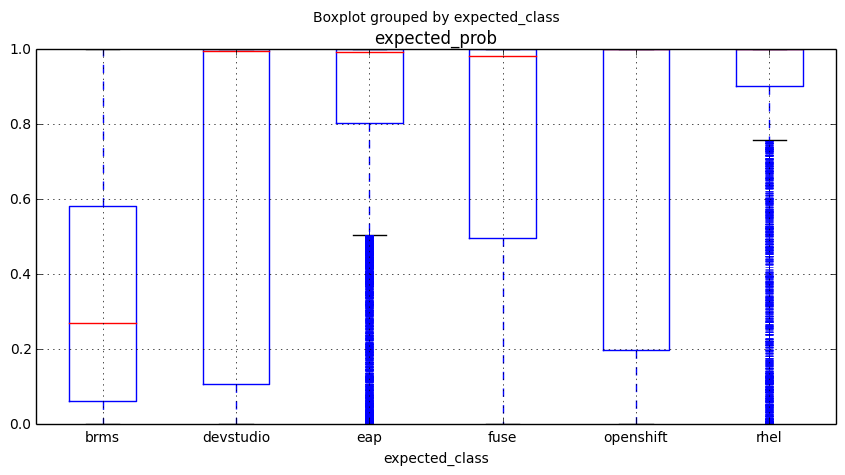

In [25]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [38]:
# incorrect classification characteristics
wrong_docs_ids = correct_logits[correct_logits["expected_class"] != correct_logits["actual_class"]]["doc_id"]

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count    8615.000000
mean      124.281254
std       368.620801
min        10.000000
25%        19.000000
50%        31.000000
75%        68.000000
max      6358.000000
Name: doc_id, dtype: float64

In [43]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    34780.000000
mean       131.554715
std        612.542818
min         10.000000
25%         25.000000
50%         38.000000
75%         99.000000
max      72938.000000
dtype: float64

In [48]:
correct_logits["content_len"] = correct_logits["doc_id"].apply(lambda doc_id: 
                                                         len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True)))
correct_logits["content"] = correct_logits["doc_id"].apply(lambda doc_id: 
                                                     d2v_wrapper.get_doc_content(int(doc_id), word_split=False)[:100])

In [49]:
correct_logits.head(25)

,actual_class,actual_prob,doc_id,expected_class,expected_prob,content,content_len
0,devstudio,0.711019,29527.0,devstudio,0.711019,jbide palett drool enabl disabl previous fulli...,11
1,brms,0.665766,37177.0,rhel,0.056326,product version level updat visibl red hat jbo...,34
2,fuse,0.999976,23022.0,fuse,0.999976,contain creat fuse delet properli.npe thrown c...,415
3,rhel,0.999999,34557.0,rhel,0.999999,buffer overflow cairo truetyp index uc functio...,26
4,eap,0.997244,10006.0,eap,0.997244,earlier releas jboss quot jboss xml quot file ...,36
5,fuse,0.999201,23327.0,fuse,0.999201,creat manual camel context rubi.code java.fina...,58
6,fuse,0.987835,20793.0,fuse,0.987835,need add rbac configur file fusesourc mbean ob...,12
7,openshift,0.999999,40469.0,openshift,0.999999,try deploi simpl ror openshift rubi mysql app ...,140
8,eap,0.831014,4711.0,eap,0.831014,look tutori portlet internet good.need migrat ...,48
9,fuse,0.999994,21553.0,fuse,0.999994,karaf client return welcom messag.regress fuse...,67


In [51]:
wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=False))[125:130].tolist()

['ew tomcat support remot access jndi tree abl lookup jndi extern jvm.',
 'jboss unrespons thread dump jbossweb thread pool max thread socketread seen sampl http thread stack trace quot http quot daemon prio tid xffc nid runnabl xfdfc java lang thread state runnabl java net socketinputstream socketread nativ method java net socketinputstream read socketinputstream java org apach coyot http internalinputbuff internalinputbuff java org apach coyot http internalinputbuff parserequestlin internalinputbuff java org apach coyot http httpprocessor process httpprocessor java org apach coyot http httpprotocol httpconnectionhandl process httpprotocol java org apach tomcat util net jioendpoint worker run jioendpoint java java lang thread run thread java sampl ajp thread stack trace quot ajp quot daemon prio tid xfbb nid runnabl xfb java lang thread state runnabl java net socketinputstream socketread nativ method java net socketinputstream read socketinputstream java java net socketinputstream rea